In [123]:
import string
import re
from collections import defaultdict
import random
import pickle
import gc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import pyLDAvis.gensim

import os
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

Folder "C:\Users\GyorgyM\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [111]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
tweets_csv = pd.read_csv("Data/twcs.csv")

# nltk.download("stopwords")
# nltk.download("wordnet")

tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

i = 1
while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]
    
#     i = i + 1
#     if i > 1:
#         break


results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


In [4]:
tweets.groupby("channel").count().sort_values("conversation_id", ascending=False)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id
channel,,,,,,,,
AmazonHelp,370222,370222,370222,370222,370222,251311,288378,370222
AppleSupport,237443,237443,237443,237443,237443,149034,157129,237443
Uber_Support,127801,127801,127801,127801,127801,78613,86038,127801
SpotifyCares,91459,91459,91459,91459,91459,58757,63278,91459
Delta,86553,86553,86553,86553,86553,50899,60595,86553
AmericanAir,85822,85822,85822,85822,85822,54815,59757,85822
TMobileHelp,79242,79242,79242,79242,79242,49899,56762,79242
Tesco,71824,71824,71824,71824,71824,39682,55236,71824
comcastcares,71468,71468,71468,71468,71468,42432,47660,71468


In [44]:
channel_tweets = tweets[tweets.channel == "Uber_Support"]
channel_conversations = channel_tweets.groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
channel_conversations.head()

conversation_id
113    @115872 Happy to follow up! Contact us via htt...
114    @115874 We're here to help! Send us a note her...
115    @115875 We’re here to help, Travis! Send us a ...
116    @115876 For more info about UberEats availabil...
117    @115878 We have received your DM and will foll...
Name: text, dtype: object

In [7]:
channel_conversations.to_csv("Data/channel_conversations.csv")

In [45]:
tokenizer = RegexpTokenizer(r"[\w-]+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
num_pattern = re.compile(r"[0-9-]+$")
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
# sign_pattern = re.compile(r"[\^-]")

def get_cleaned_doc(doc):
    url_removed = url_pattern.sub("?", doc)
    lower = url_removed.lower()
    tokenized = tokenizer.tokenize(lower)
    stop_removed = [word for word in tokenized if word not in stop]
    num_removed = [word for word in stop_removed if num_pattern.match(word) is None]
#     lemmatized = [lemmatizer.lemmatize(word) for word in num_removed]
    return num_removed

documents = [get_cleaned_doc(doc) for doc in channel_conversations]

In [49]:
rand_ind = np.random.randint(len(documents))
print(rand_ind)
print(channel_conversations.iloc[rand_ind])
print(documents[rand_ind])

35934
@736909 Here to help! Can you please send us a DM with your email address so we can assist? @Uber_Support Already did that, it said that they will reply within 24 hours.

My wife ate half my food, please can we do something else? @736909 Here to help! Send us a note at https://t.co/ZFaWy0Lkdu so our team can connect right away. Hey @Uber_Support - my order from Ubereats did not have all the required items and my wife now hates me - when can I get this fixed asap, I do not want to wait 24 hours!
['help', 'please', 'send', 'us', 'dm', 'email', 'address', 'assist', 'uber_support', 'already', 'said', 'reply', 'within', 'hours', 'wife', 'ate', 'half', 'food', 'please', 'something', 'else', 'help', 'send', 'us', 'note', 'team', 'connect', 'right', 'away', 'hey', 'uber_support', 'order', 'ubereats', 'required', 'items', 'wife', 'hates', 'get', 'fixed', 'asap', 'want', 'wait', 'hours']


In [46]:
word_freq = defaultdict(int)
for doc in documents:
    for token in doc:
        word_freq[token] += 1

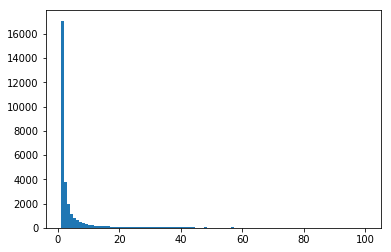

In [48]:
plt.hist(word_freq.values(), bins=100, range=(1, 100));

In [47]:
dictionary = corpora.Dictionary(documents)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]
print("dictionary size: " + str(dictionary.num_pos))

dictionary size: 1203586


In [124]:
random.shuffle(doc_term_matrix)

In [142]:
logging.getLogger().setLevel(logging.WARNING)

first_val = int(0.9 * len(doc_term_matrix))

train = doc_term_matrix[:first_val]
val = doc_term_matrix[first_val:]

# tfidf = models.TfidfModel(doc_term_matrix, dictionary=dictionary)
lda_input = train
# lda = models.LdaMulticore(lda_input, id2word=dictionary, num_topics=40, alpha='asymmetric', eta=0.01, workers=7, iterations=200, passes=3)
lda = models.LdaModel(lda_input, id2word=dictionary, num_topics=20, alpha='auto', eta='auto', iterations=200, passes=3)
# model = models.LdaModel(doc_term_matrix, id2word=dictionary, num_topics=10, iterations=400, passes=20, eval_every=1)

c:\users\gyorgym\apps\miniconda3\envs\dl\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


KeyboardInterrupt: 

In [141]:
logging.getLogger().setLevel(logging.WARNING)
print(lda.log_perplexity(train))
print(lda.log_perplexity(val))

-15.24847247641827
-16.427787228813948


In [117]:
prepared = pyLDAvis.gensim.prepare(lda, lda_input, dictionary, mds="tsne")

2018-08-09 12:55:36,195 : DEBUG : performing inference on a chunk of 41763 documents
2018-08-09 12:55:59,434 : DEBUG : 41737/41763 documents converged within 200 iterations


In [118]:
pyLDAvis.display(prepared)

In [17]:
gc.collect()

643